# Vent Data Exploration

Before diving into Emotion Detection / Classification, it's a good idea to take a look at our data to see if there may be formatting problems, noisy data, or other similar aspects that might lower data quality and make our task harder. Onwards!

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
ROOT_PATH = str(Path('.').parent.absolute().parent)

vent = pd.read_csv('{}/data/vents.csv'.format(ROOT_PATH))

In [3]:
import re


def deitalize(string):
    return string.replace('_', '')

def reduce_whitespace(string):
    return re.sub('\s+', ' ', string)

def normalize_text(string):
    if string is None:
        return ''
    string = str(string)
    replaced_refs = string.replace('_USER_REFERENCE_', '[NAME]')
    replaced_urls = replaced_refs.replace('_URL_/', '[URL]').replace('_URL_', '[URL]')
    undo_italics = deitalize(replaced_urls)
    parse_whitespace = reduce_whitespace(undo_italics).strip()
    return parse_whitespace


In [4]:
vent.text = [normalize_text(text) for text in vent.text]

In [5]:
print('\n\n$$$$$$$$$$$$$$$$$$$$$$$\n\n'.join(vent.text[-10:].tolist()))

I'm so sorry hun you lost the love of your life. You lost your "first" babe. I'm so sorry. I was in your position 3 years back and unfortunately you survive it. I'm SO sorry... If there's anything I can do. I'm not sexier. I'm not better. But eventually you will need sex again and I'll be here. I love you. I'm not your first choice. But I'll be a choice. I just want you to know I care. If I'm a rebound I'm honored to be one.

$$$$$$$$$$$$$$$$$$$$$$$

Sex.

$$$$$$$$$$$$$$$$$$$$$$$

#nsfw // That night all I wanted to do was spread my legs and hop on it so fast and hard and I miss you. I really miss you.

$$$$$$$$$$$$$$$$$$$$$$$

I don't want to go back to work when I go home Saturday. Ugh

$$$$$$$$$$$$$$$$$$$$$$$

I miss you Cesar. Will you ever come back?? // What did I do WRONG?!?!?

$$$$$$$$$$$$$$$$$$$$$$$

I won $110!!!!!

$$$$$$$$$$$$$$$$$$$$$$$

My mom doesn't shut the fuck up.

$$$$$$$$$$$$$$$$$$$$$$$

I've been spending way too much money.

$$$$$$$$$$$$$$$$$$$$$$$

You know what

# Vent Length Analysis

Another important aspect is to choose an appropriate length for the input sequences. Let's take a look at the data.

In [6]:
import string

SEPARATOR_CHAR_SET = set(string.whitespace + string.punctuation)

def count_tokens(string):
    previous_sep = False
    separator_count = 0
    for char in string:
        if char in SEPARATOR_CHAR_SET:
            if previous_sep:
                continue
            previous_sep = True
            separator_count += 1
        else:
            previous_sep = False
    # Do not count trailing separator
    if previous_sep:
        separator_count -= 1
    return separator_count + 1


In [7]:
vent_token_counts = [count_tokens(string) for string in vent.text]

In [8]:
len(vent_token_counts)

33774613

In [9]:
np.mean(vent_token_counts)

32.25184466214313

In [10]:
percentiles = [50, 75, 90]
pct_values = np.percentile(vent_token_counts, percentiles)
pct_values

array([17., 32., 60.])

In [11]:
np.std(vent_token_counts)

76.90582684608755

In [12]:
np.max(vent_token_counts)

184813

In [13]:
import matplotlib.pyplot as plt

min_token_bound = 3
max_token_bound = 32
tokens_within_bounds = [x for x in vent_token_counts if min_token_bound <= x and x <= max_token_bound]

print('Total instances within the token number bounds: {}'.format(len(tokens_within_bounds)))

plt.yscale('log')
plt.hist(tokens_within_bounds, 
         bins=np.arange(min_token_bound - 0.5, max_token_bound + 1, 1))

Total instances within the token number bounds: 24541354


(array([ 695506.,  975024., 1185143., 1279283., 1291781., 1274357.,
        1235547., 1189021., 1148001., 1113302., 1066882., 1021154.,
         974490.,  922943.,  870189.,  847318.,  769047.,  732609.,
         679516.,  638134.,  600429.,  567179.,  532319.,  501058.,
         470967.,  442445.,  415002.,  391176.,  366365.,  345167.]),
 array([ 2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5,
        13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5,
        24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <a list of 30 Patch objects>)

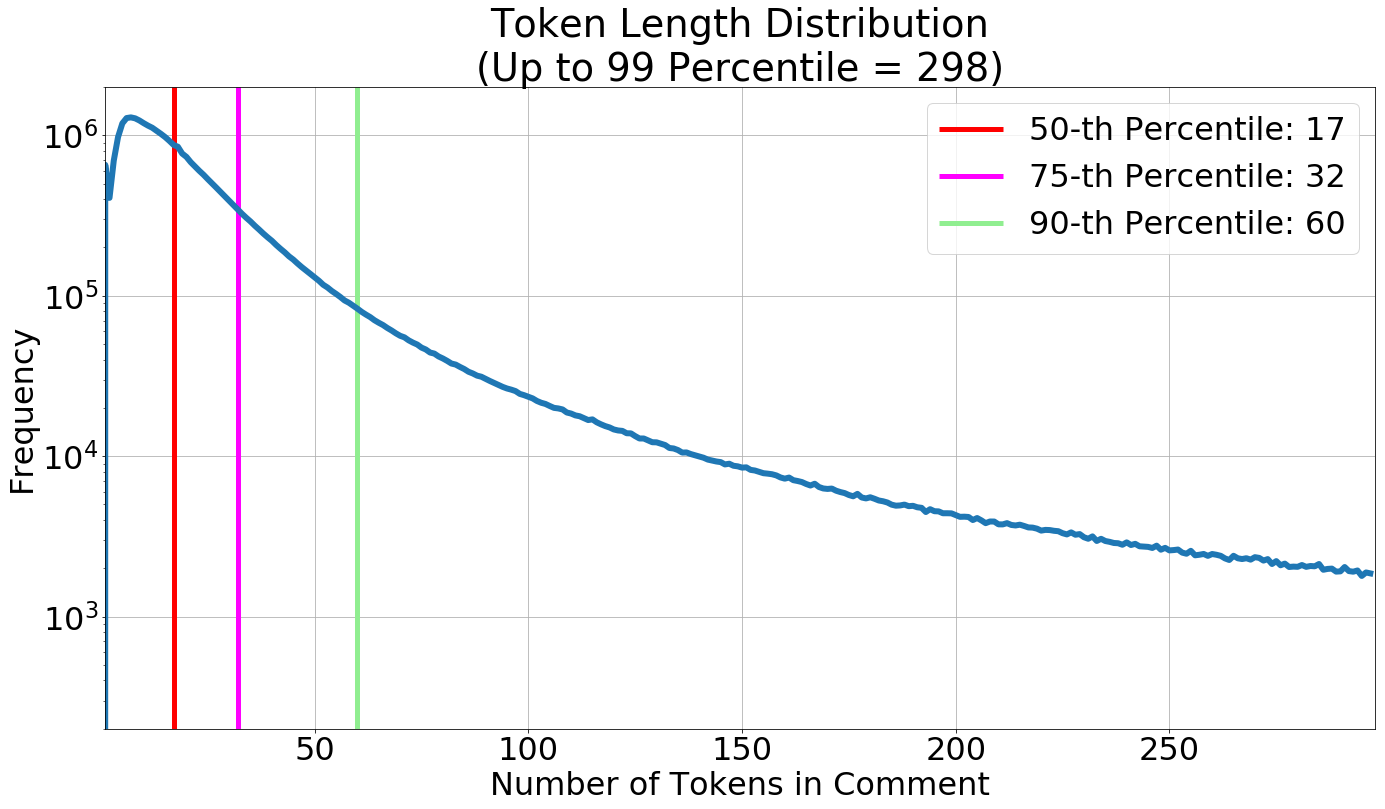

In [14]:
import matplotlib

threshold = int(np.percentile(vent_token_counts, 99))

plt.figure(figsize=(20, 12))
matplotlib.rcParams.update({'font.size': 32})

plt.yscale('log')
plt.title(f'Token Length Distribution\n(Up to 99 Percentile = {threshold})')
plt.ylabel('Frequency')
plt.xlim(1, threshold)
plt.ylim(200, 2e6)
plt.xlabel('Number of Tokens in Comment')
#bins, _, _ = plt.hist([x for x in vent_token_counts if x < threshold], bins=np.arange(-0.5, threshold + 1, 1))
bins_range = np.arange(0, threshold + 1, 1)
bins, _ = np.histogram([x for x in vent_token_counts if x < threshold], bins=bins_range)
plt.plot(bins_range[:-1], bins, linewidth=6)
bin_heights = bins[pct_values.astype('int')]
colors = ['red', 'magenta', 'lightgreen']
for value, height, pct, color in zip(pct_values, bin_heights, percentiles, colors):
    value = int(value)
    plt.vlines(value, ymin=0, ymax=2e6, linewidths=5, color=color, label=f'{pct}-th Percentile: {value}')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../output/VentTokenLengthDistribution.pdf')

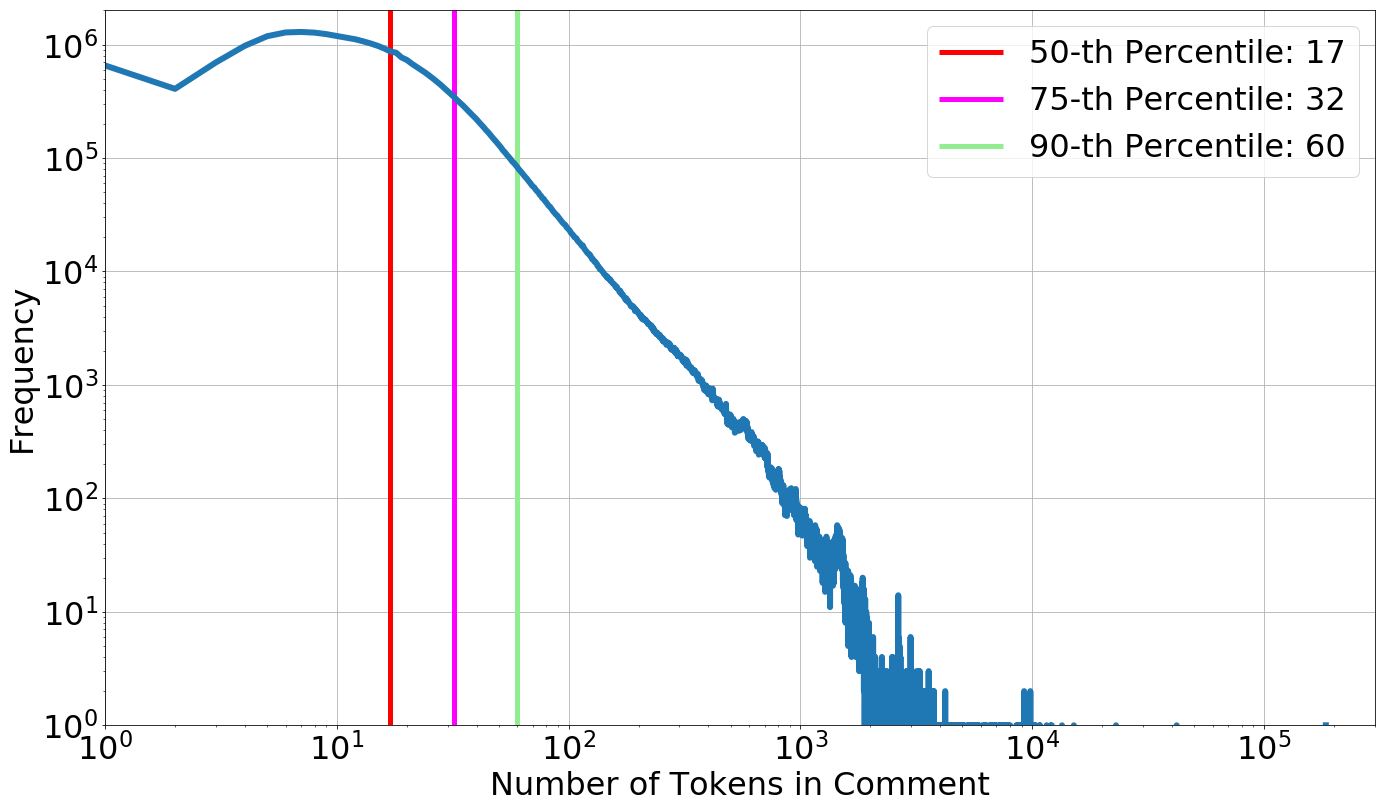

In [52]:
import matplotlib

threshold = max(vent_token_counts)

plt.figure(figsize=(20, 12))
matplotlib.rcParams.update({'font.size': 32})

plt.yscale('log')
plt.xscale('log')
#plt.title('Full Token Length Distribution')
plt.ylabel('Frequency')
plt.ylim(1, 2e6)
plt.xlim(1, 3e5)
plt.xlabel('Number of Tokens in Comment')
#bins, _, _ = plt.hist([x for x in vent_token_counts if x < threshold], bins=np.arange(-0.5, threshold + 1, 1))
bins_range = np.arange(0, threshold + 1, 1)
bins, _ = np.histogram(vent_token_counts, bins=bins_range)
plt.plot(bins_range[:-1], bins, linewidth=6)
bin_heights = bins[pct_values.astype('int')]
colors = ['red', 'magenta', 'lightgreen']
for value, height, pct, color in zip(pct_values, bin_heights, percentiles, colors):
    value = int(value)
    plt.vlines(value, ymin=0, ymax=2e6, linewidths=5, color=color, label=f'{pct}-th Percentile: {value}')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('../output/VentTokenLengthFullDistribution.pdf')

# Study the behaviour of the filtered data set

In [16]:
vent_preprocessed = pd.read_parquet('{}/preprocessed/vent.parquet'.format(ROOT_PATH))

In [17]:
emo_counts = vent_preprocessed.groupby(['emotion_categories_label', 'emotions_label']).size()

In [18]:
emo_counts_frame = emo_counts.reset_index()
emo_counts_frame.columns = ['category', 'emotion', 'count'] 

category_counts = emo_counts_frame.groupby(['category'])['count'].sum().reset_index()
category_counts.columns = ['category', 'category_count'] 

all_counts = emo_counts_frame.merge(category_counts, on='category', how='inner').sort_values(['category_count', 'count'], ascending=False)
all_counts

,category,emotion,count,category_count
81,7,74,908197,4126605
77,7,53,622141,4126605
79,7,57,443542,4126605
73,7,27,375952,4126605
74,7,32,354871,4126605
...,...,...,...,...
62,6,19,80027,789559
66,6,58,61910,789559
70,6,84,58325,789559
69,6,75,42245,789559


In [19]:
emo_df = pd.read_csv('{}/data/emotions_clean.csv'.format(ROOT_PATH))
cat_df = pd.read_csv('{}/data/emotion_categories_clean.csv'.format(ROOT_PATH))

emo_indices = {i: str(n) for i, n in enumerate(emo_df.name.sort_values().tolist())}
cat_indices = {i: str(n) for i, n in enumerate(cat_df.name.sort_values().tolist())}

all_counts.emotion = [emo_indices[emo] for emo in all_counts.emotion.tolist()]
all_counts.category = [cat_indices[cat] for cat in all_counts.category.tolist()]

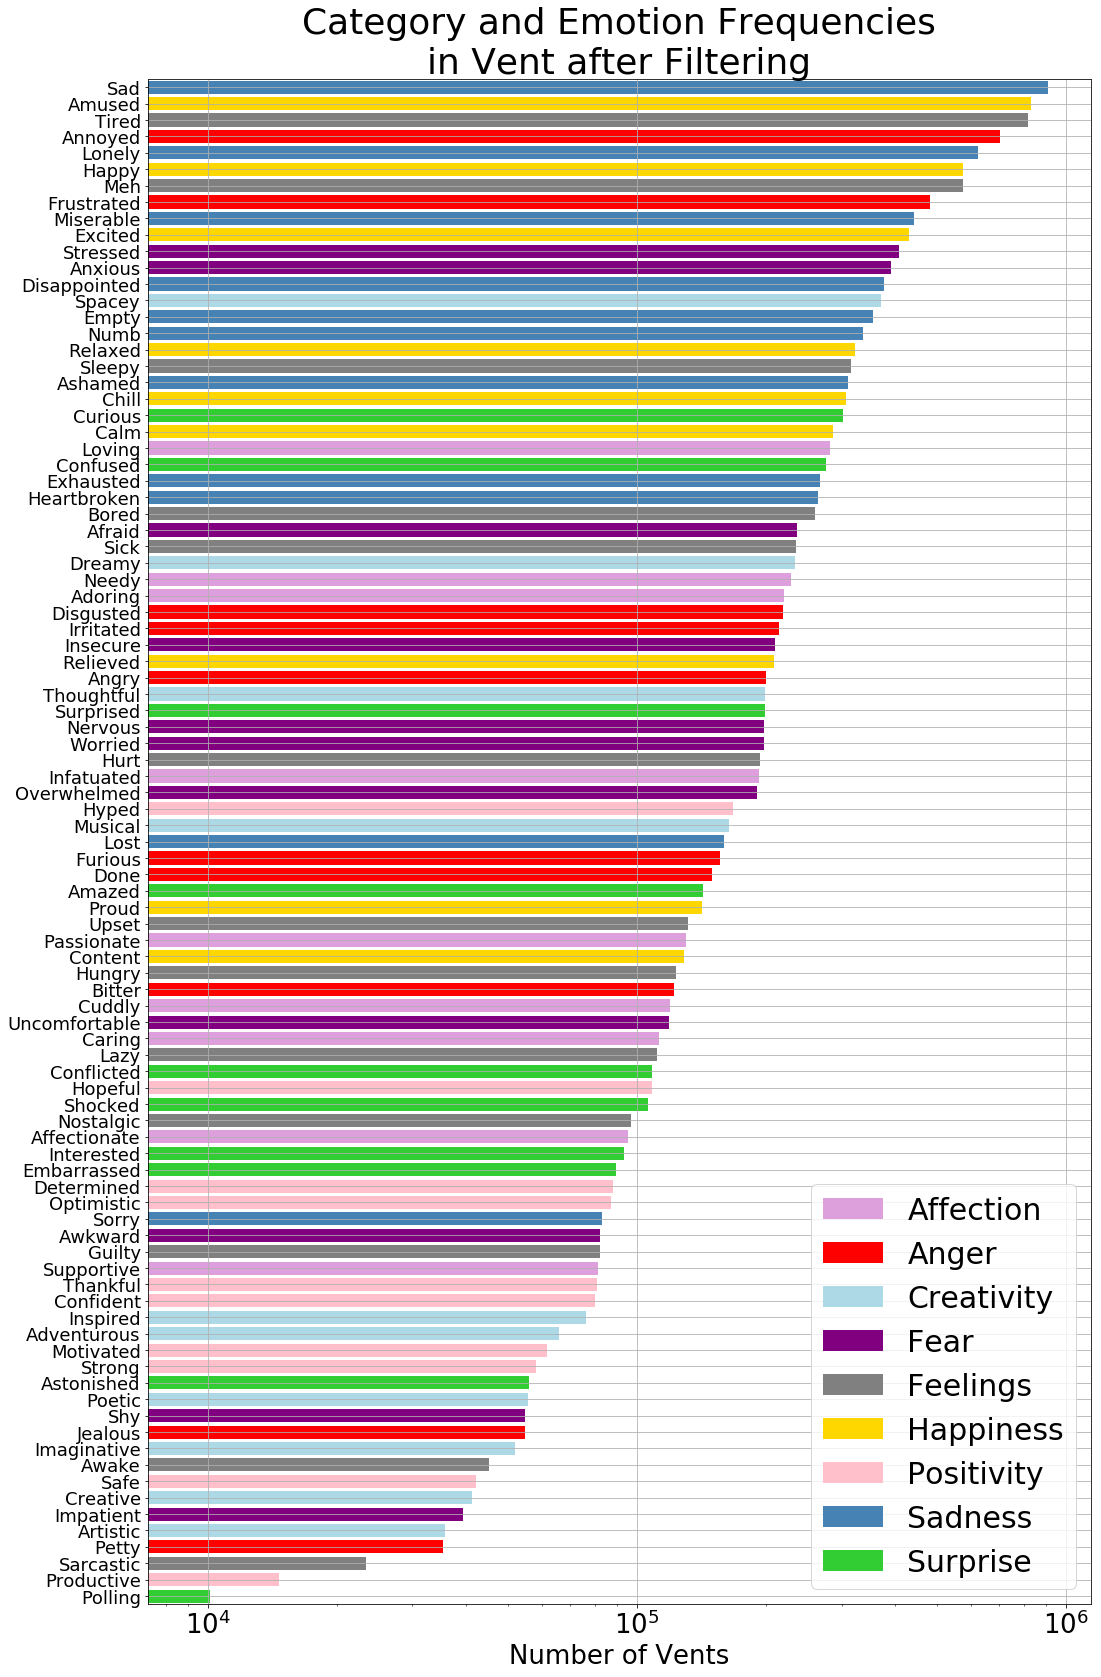

In [20]:
import matplotlib.patches as mpatches


by_count = all_counts.sort_values('count', ascending=True)

num_emos = len(emo_df)

# Prepare the data
y_pos = np.arange(0.5, num_emos, 1.0) 
categories = by_count.category.tolist()
category_set = sorted(set(categories))
num_cats = len(category_set)
color_list = ['plum', 'red', 'lightblue', 'purple', 'grey', 'gold', 'pink', 'steelblue', 'limegreen']
color_map = {cat: col for cat, col in zip(category_set, color_list)}
colors = [color_map[cat] for cat in categories]
all_hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_map = {cat: all_hatches[i] for i, cat in enumerate(category_set)}
hatches = [hatch_map[cat] for cat in categories]

# Set the environment
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 24))
plt.xscale('log')
plt.ylim(0, num_emos)
plt.yticks(y_pos, by_count.emotion.tolist())


# Plot each line with hatches
for category in category_set:
    y, c, cat, col, hat = zip(*[t for t in zip(y_pos, by_count['count'].tolist(), categories, colors, hatches) if t[2] == category])
    col = col[0]
    hat = hat[0]
    plt.barh(y, c, label=cat, color=col)# , hatch=hat)

matplotlib.rcParams.update({'font.size': 30})
plt.xlabel('Number of Vents', fontsize=26)
plt.xticks(fontsize=26)
plt.title('Category and Emotion Frequencies\nin Vent after Filtering')
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set]) #  hatch=hatch_map[cat]
plt.grid()
plt.tight_layout()
plt.savefig('../output/VentEmotionAndCategoryFrequencies.pdf')

# Analyse the temporal / stationary aspects of the emotional signal

In [21]:
vent_preprocessed['emotion'] = [emo_indices[emo] for emo in vent_preprocessed.emotions_label.tolist()]
vent_preprocessed['category'] = [cat_indices[cat] for cat in vent_preprocessed.emotion_categories_label.tolist()]
vent_preprocessed['month'] = vent_preprocessed.created_at.dt.strftime('%Y-%m')

In [22]:
month_emo_counts = vent_preprocessed.groupby(['month', 'category', 'emotion']).size().reset_index()
month_emo_counts.columns = ['month', 'category', 'emotion', 'count']

In [23]:
month_counts = month_emo_counts.groupby('month')['count'].sum().reset_index()
month_counts.columns = ['month', 'total_count']

In [24]:
month_emo_pct = month_emo_counts.merge(month_counts, on='month', how='inner')
month_emo_pct['percent'] = month_emo_pct['count'] / month_emo_pct.total_count

In [25]:
from matplotlib import cm

month_emo_subset = month_emo_pct

emo_freqs = month_emo_subset.groupby(['category', 'emotion'])['count'].sum().reset_index()
emo_freqs.columns = ['category', 'emotion', 'emo_count']
emo_freqs['emo_freq'] = emo_freqs.emo_count / emo_freqs.emo_count.sum()
emo_freqs = emo_freqs.sort_values('emotion')

num_emos = len(emo_freqs)

colors = [(i / num_emos) for i, _ in emo_freqs.iterrows()]
emo_freqs['coloring'] = [cm.rainbow(c) for c in colors]
emo_freqs['gray'] = [cm.gray(c) for c in colors]

emo_colors = emo_freqs[['category', 'emotion', 'coloring', 'gray', 'emo_freq']]

month_emo_subset = month_emo_subset.merge(emo_colors, on=['category', 'emotion'], how='inner').sort_values(['month', 'emotion'])

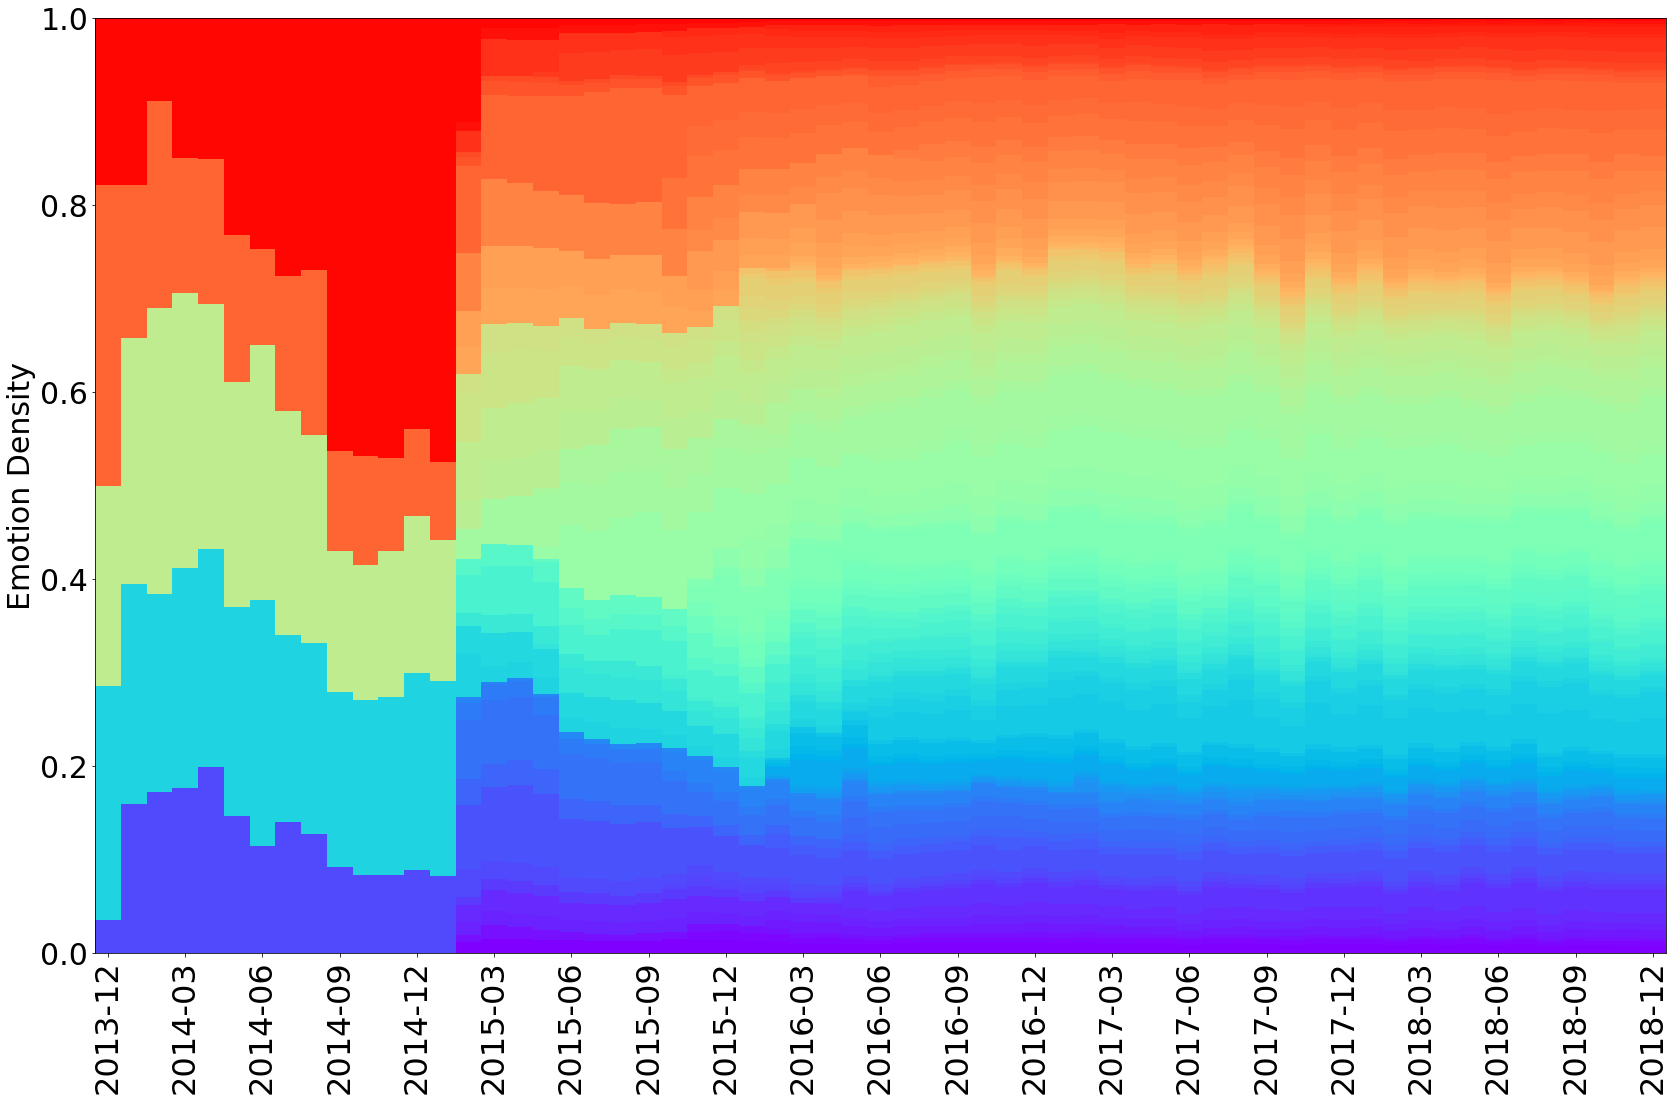

In [45]:
plt.figure(figsize=(24, 16))

index = 0.5
width = 1
matplotlib.rcParams.update({'font.size': 30})
for grp, df in month_emo_subset.groupby('month'):
    prob_sum = 0.0
    for i, row in df.sort_values(['category', 'emotion']).iterrows():
        pct = row.percent
        plt.bar(index, height=pct, width=width, bottom=prob_sum, label=row.month, color=row.coloring)
        prob_sum += pct
    index += 1
    
months = month_emo_subset.month.unique()
plt.xticks([x + 0.5 for x in range(len(months))][::3], months[::3], rotation='vertical', fontsize=32) 
plt.xlim(0, len(months))
plt.ylim(0, 1)
#plt.title('Emotion Densities over Vent Month-by-Month')
plt.ylabel('Emotion Density')
plt.tight_layout()
plt.savefig('../output/EmoDensitiesMonthly.pdf')
plt.show()

In [27]:
from matplotlib.colors import to_rgba

category_colors = dict(zip(month_emo_subset.category.unique(), map(to_rgba, color_list)))

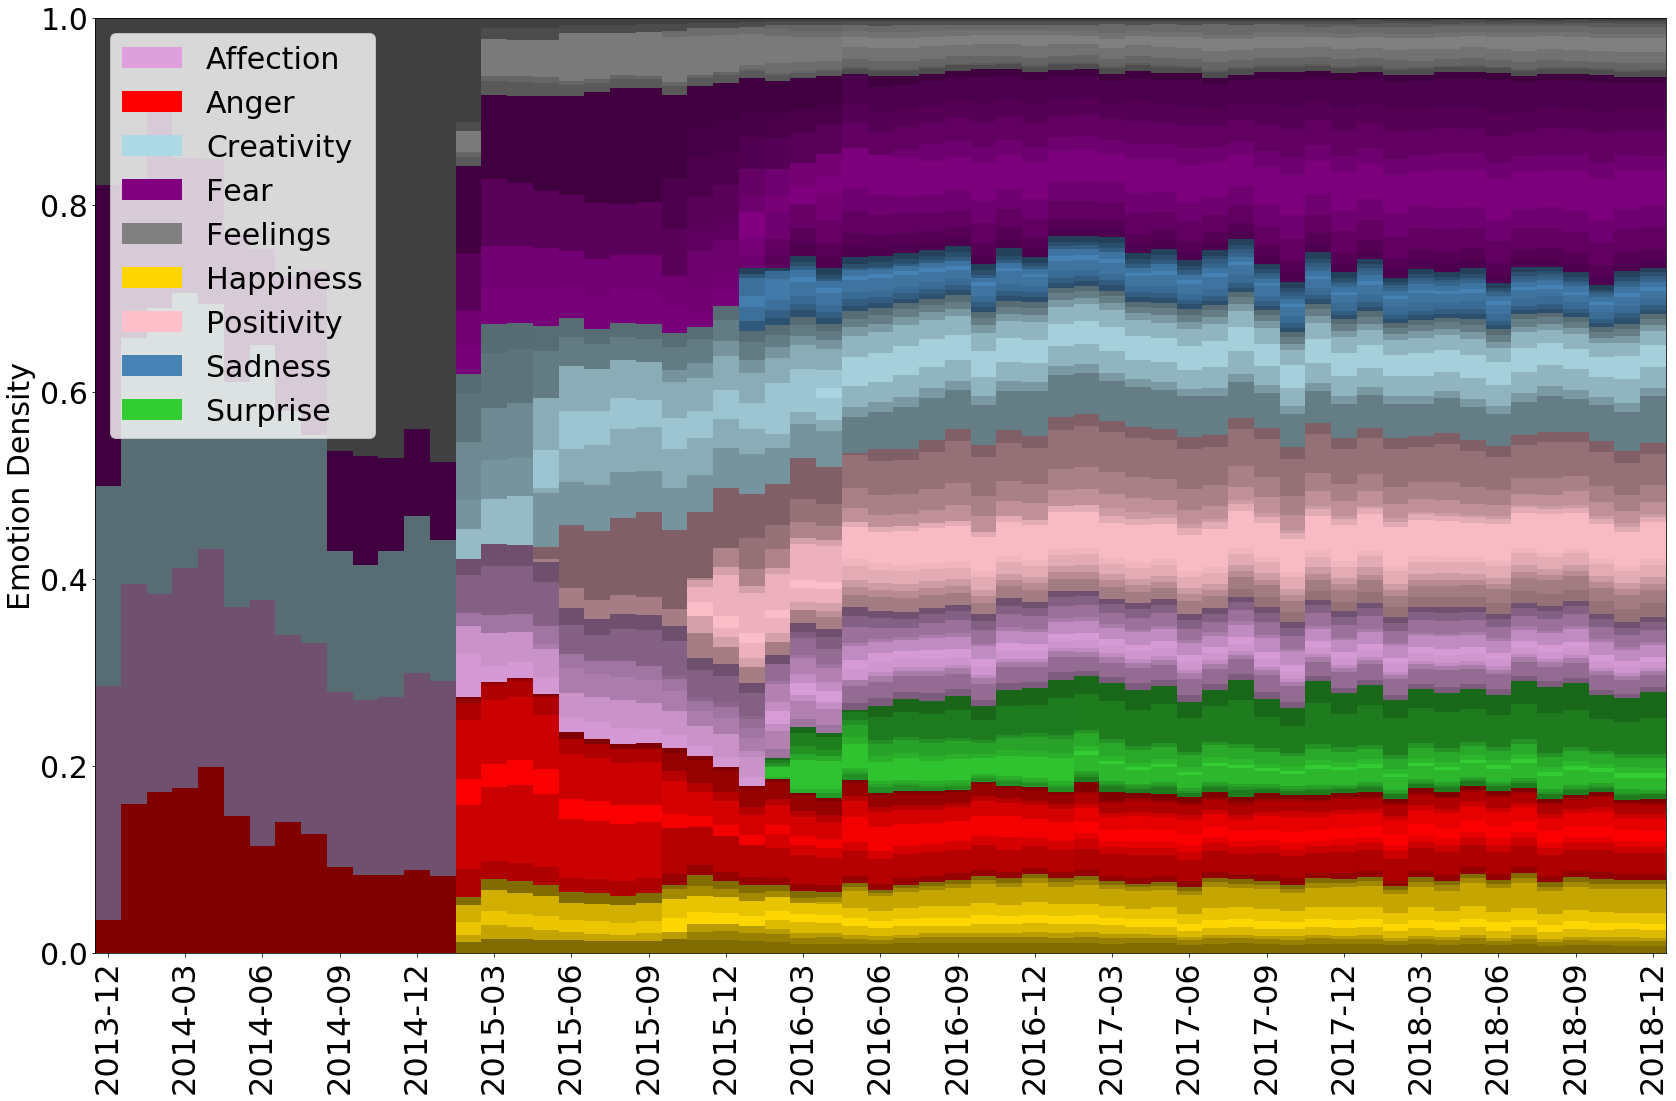

In [46]:
plt.figure(figsize=(24, 16))

def compute_color(cat_color, row_gray, center, delta, whitening_fraction=0.5):
    centered_gray = 1 - abs(center - row_gray) / delta
    whitened_gray = whitening_fraction * centered_gray + (1 - whitening_fraction)
    clipped_gray = min(1, max(0, whitened_gray))
    clipped_color = clipped_gray * cat_color
    return clipped_color

def compute_category_stats(month_df):
    top_colors = month_df.groupby('category').graybase.max().reset_index()
    top_colors.columns = ['category', 'cmax']
    top_colors['cmin'] = [0] + top_colors.cmax.tolist()[:-1]
    top_colors['delta'] = (top_colors.cmax - top_colors.cmin) / 2
    top_colors['center'] = top_colors.cmin + top_colors.delta
    return top_colors

index = 0.5
width = 1
matplotlib.rcParams.update({'font.size': 30})
for grp, df in month_emo_subset.groupby('month'):
    prob_sum = 0.0
    df['graybase'] = [gray[0] for gray in df.gray]
    category_stats = compute_category_stats(df)
    for i, row in df.sort_values(['category', 'emotion']).iterrows():
        pct = row.percent
        cat_color = category_colors[row.category]
        cat = category_stats[category_stats.category == row.category].iloc[0]
        delta = 1 if cat.delta == 0 else cat.delta
        full_color = tuple(map(lambda x: compute_color(x[0], x[1], cat.center, delta), zip(cat_color, row.gray[:3])))
        plt.bar(index, height=pct, width=width, bottom=prob_sum, label=row.month, color=full_color)
        prob_sum += pct
    index += 1
    
months = month_emo_subset.month.unique()
plt.xticks([x + 0.5 for x in range(len(months))][::3], months[::3], rotation='vertical', fontsize=32) 
plt.xlim(0, len(months))
plt.ylim(0, 1)
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set]) #  hatch=hatch_map[cat]
#plt.title('Emotion Category Densities over Vent Month-by-Month')
plt.ylabel('Emotion Density')
plt.tight_layout()
plt.savefig('../output/EmoCategoryDensitiesMonthly.pdf')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook.py:2224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


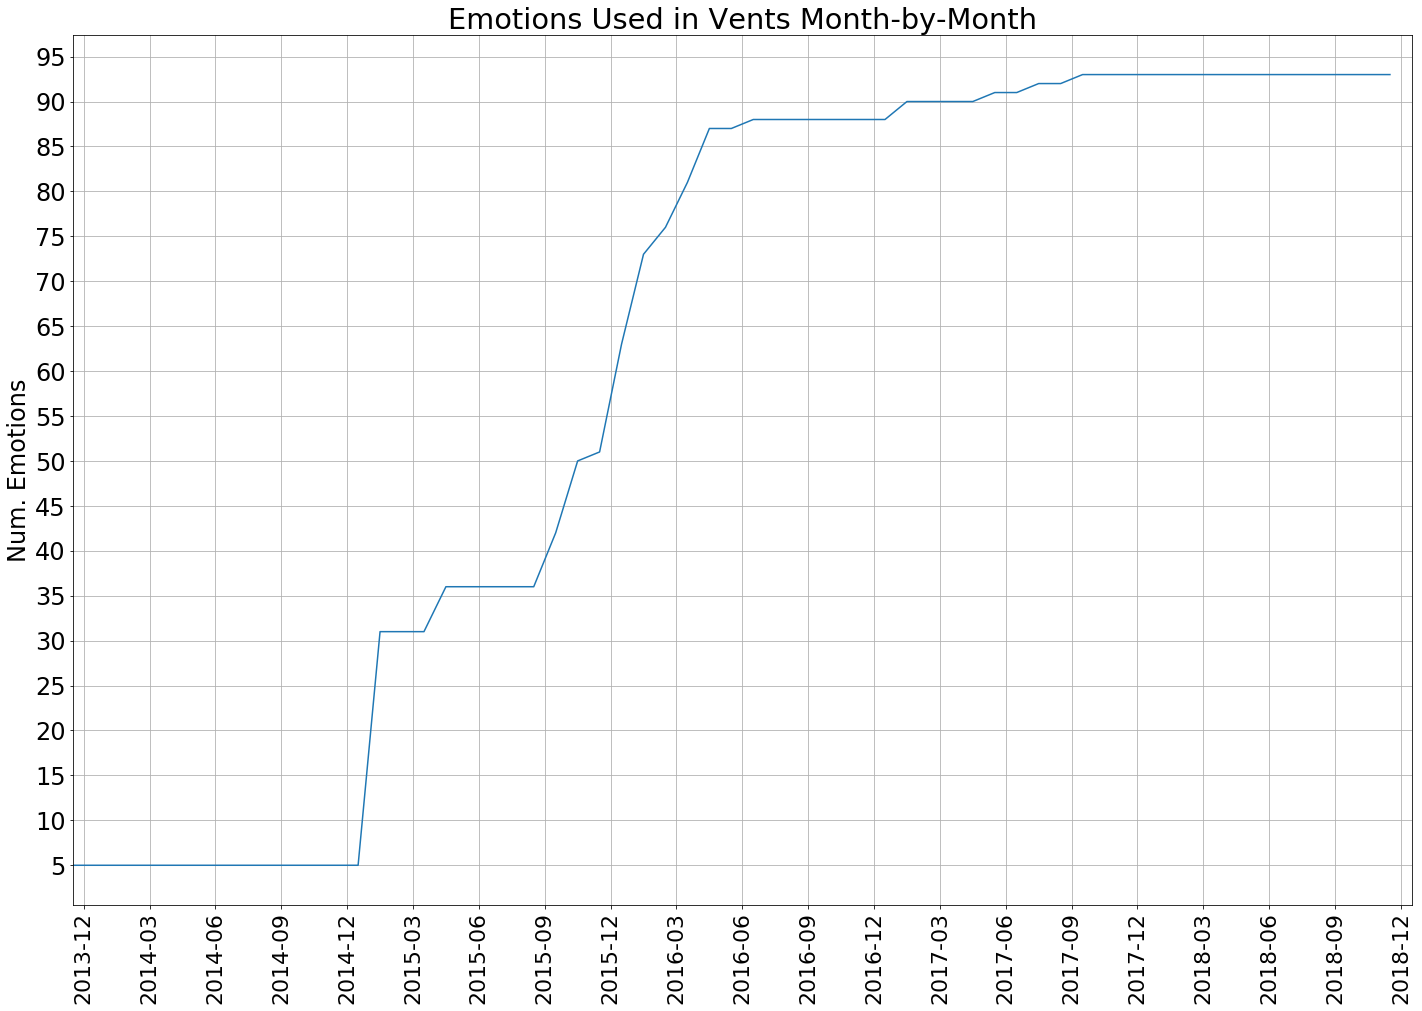

In [29]:
month_num_emos = month_emo_subset.groupby('month').size().reset_index()
month_num_emos.columns = ['month', 'num_emos']

plt.figure(figsize=(24, 16))
plt.plot(np.arange(0, len(month_num_emos.month)), month_num_emos.num_emos)
plt.xlim(0, len(months))
plt.xticks([x + 0.5 for x in range(len(months))][::3], months[::3], rotation='vertical', fontsize=22)
plt.yticks(np.arange(5, 100, 5))
plt.grid()
plt.ylabel('Num. Emotions')
plt.title('Emotions Used in Vents Month-by-Month')

In [30]:
after_plateau = month_emo_subset[month_emo_subset.month >= '2016-07']

emo_sizes = after_plateau.groupby(['category', 'emotion']).size().reset_index()
emo_sizes.columns = ['category', 'emotion', 'num_months']
robust_emotions = emo_sizes[emo_sizes.num_months == emo_sizes.num_months.max()]

robust_emotion_set = set(robust_emotions.emotion.tolist())

0.0029206091511905967


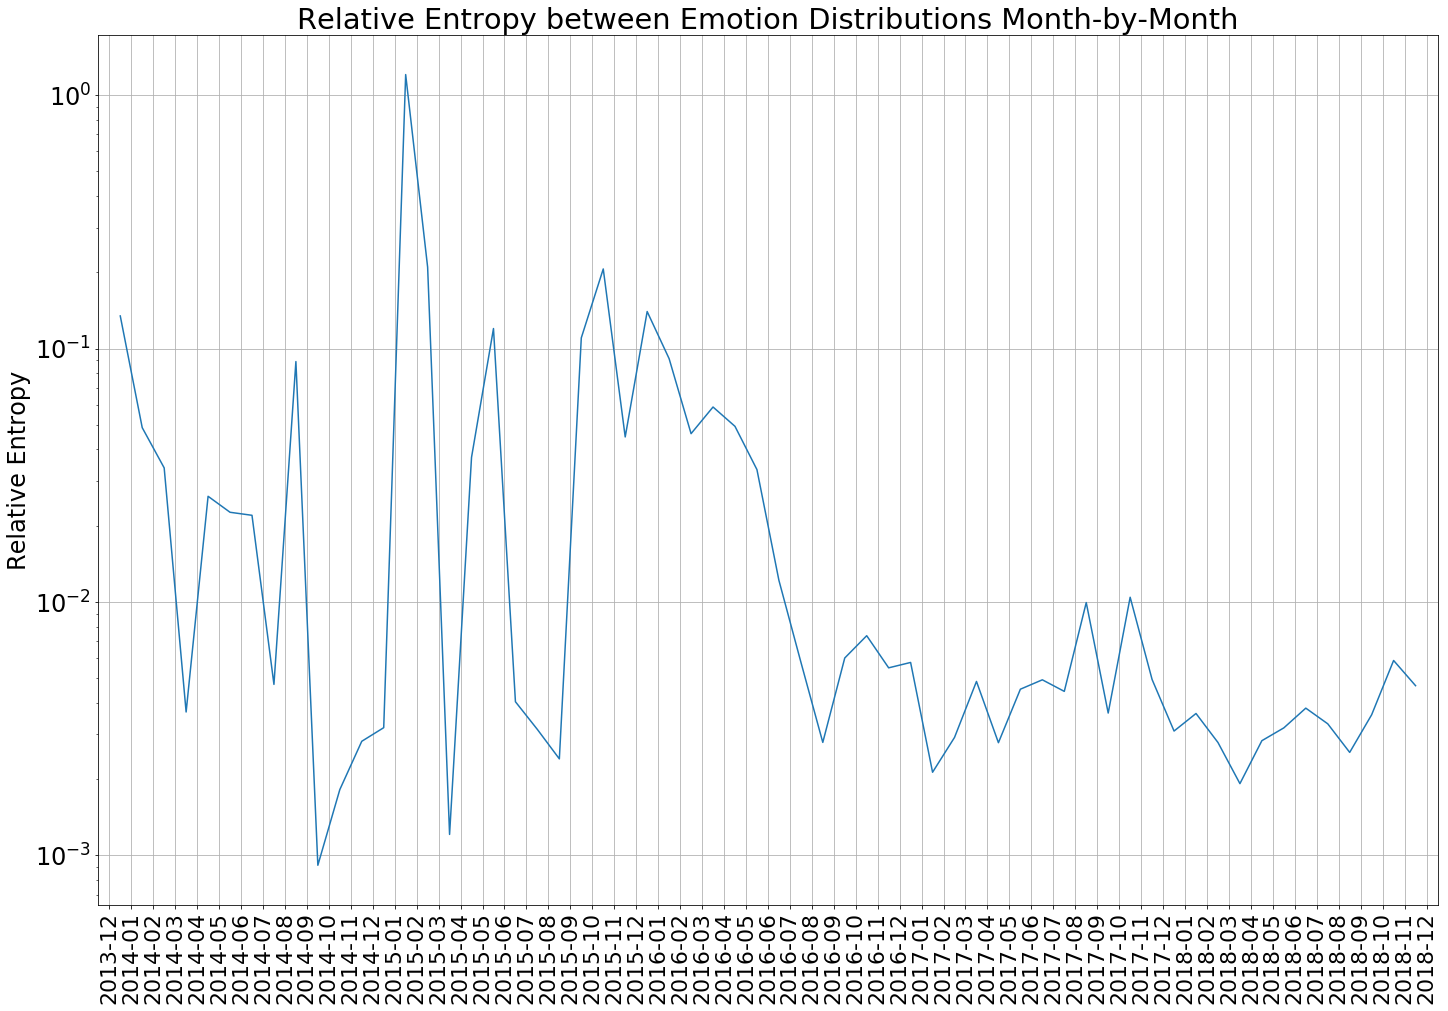

In [31]:
from scipy.stats import entropy

emotion_list = sorted(robust_emotion_set) # sorted(month_emo_subset.emotion.unique())

emo_dist = month_emo_subset.groupby('month').agg({'emotion': list, 'percent': list}).reset_index()
emo_dist['vector_components'] = [dict(zip(*pair)) for pair in zip(emo_dist.emotion, emo_dist.percent)]
emo_dist['vector'] = [np.asarray([vc.get(em, 0.0) for em in emotion_list]) for vc in emo_dist.vector_components]
emo_dist = emo_dist[['month', 'vector']]

vector_list = np.asarray(emo_dist.vector.tolist())
entropies = [float('inf')] + [entropy(v1, v2) for v1, v2 in zip(vector_list, vector_list[1:])]

i = 23
print(entropy(vector_list[-i], vector_list[-i + 1]))

ent_months = emo_dist.month.unique()
plt.figure(figsize=(24, 16))
plt.plot(np.arange(0, len(emo_dist.month)), entropies)
plt.xlim(0, len(months))
plt.yscale('log')
plt.xticks([x + 0.5 for x in range(len(ent_months))], ent_months, rotation='vertical', fontsize=22)
plt.grid()
plt.ylabel('Relative Entropy')
plt.title('Relative Entropy between Emotion Distributions Month-by-Month')

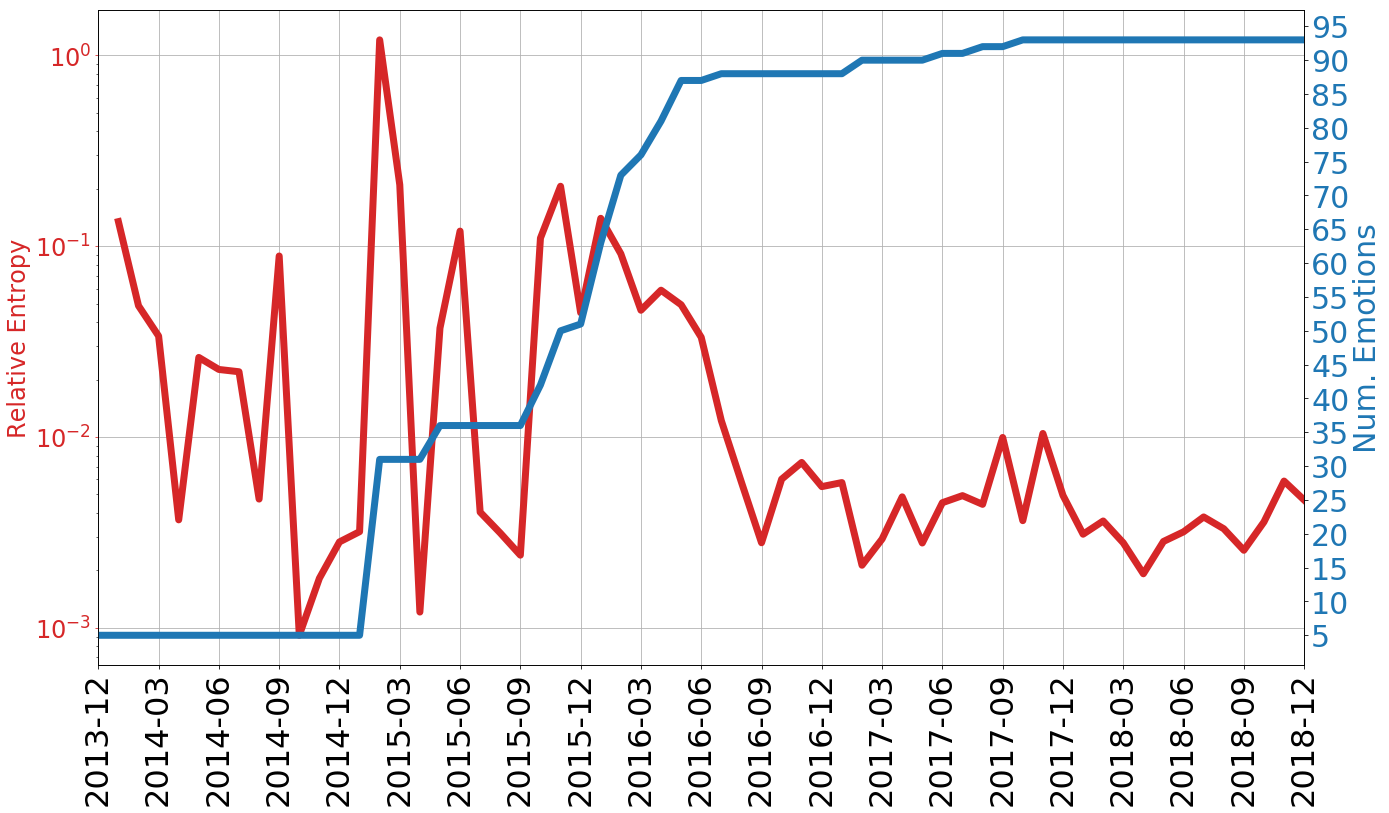

In [49]:
fig, ax1 = plt.subplots(figsize=(20, 12))

matplotlib.rcParams.update({'font.size': 30})

plt.xlim(0, len(months))
plt.xticks([x for x in range(len(ent_months))][::3], ent_months[::3], rotation='vertical', fontsize=32)

color = 'tab:red'
ax1.plot(np.arange(0, len(emo_dist.month)), entropies, color=color, linewidth=7)
ax1.tick_params(axis='y', labelcolor=color, color=color)
ax1.grid()
ax1.set_yscale('log')
ax1.set_ylabel('Relative Entropy', color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(np.arange(0, len(month_num_emos.month)), month_num_emos.num_emos, color=color, linewidth=7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(5, 100, 5))
ax2.set_ylabel('Num. Emotions', color=color)

plt.xlim(0, len(month_num_emos.month) - 1)
#plt.title('Number of Emotions and Relative Entropy\nbetween Emotion Distributions Month-by-Month')
plt.tight_layout()
plt.savefig('../output/EntropyEmoNumbersMonthly.pdf')

In [33]:
emo_counts_robust = vent_preprocessed[vent_preprocessed.month >= '2016-07'].groupby(['emotion_categories_label', 'emotions_label']).size().reset_index()
emo_counts_robust.columns = ['emotion_categories_label', 'emotions_label', 'count']
emo_counts_robust['emotion'] = [emo_indices[emo] for emo in emo_counts_robust.emotions_label.tolist()]
emo_counts_robust['category'] = [cat_indices[cat] for cat in emo_counts_robust.emotion_categories_label.tolist()]

category_rob_counts = emo_counts_robust.groupby(['category'])['count'].sum().reset_index()
category_rob_counts.columns = ['category', 'category_count'] 

all_robust_counts = emo_counts_robust.merge(category_rob_counts, on='category', how='inner').sort_values(['category_count', 'count'], ascending=False)
all_robust_counts

,emotion_categories_label,emotions_label,count,emotion,category,category_count
81,7,74,269151,Sad,Sadness,1938925
79,7,57,249664,Miserable,Sadness,1938925
75,7,34,214922,Exhausted,Sadness,1938925
77,7,53,214083,Lonely,Sadness,1938925
74,7,32,202485,Empty,Sadness,1938925
...,...,...,...,...,...,...
62,6,19,48574,Confident,Positivity,523562
70,6,84,43494,Strong,Positivity,523562
66,6,58,39121,Motivated,Positivity,523562
69,6,75,33816,Safe,Positivity,523562


There are 9874626 vents after robust filtering.


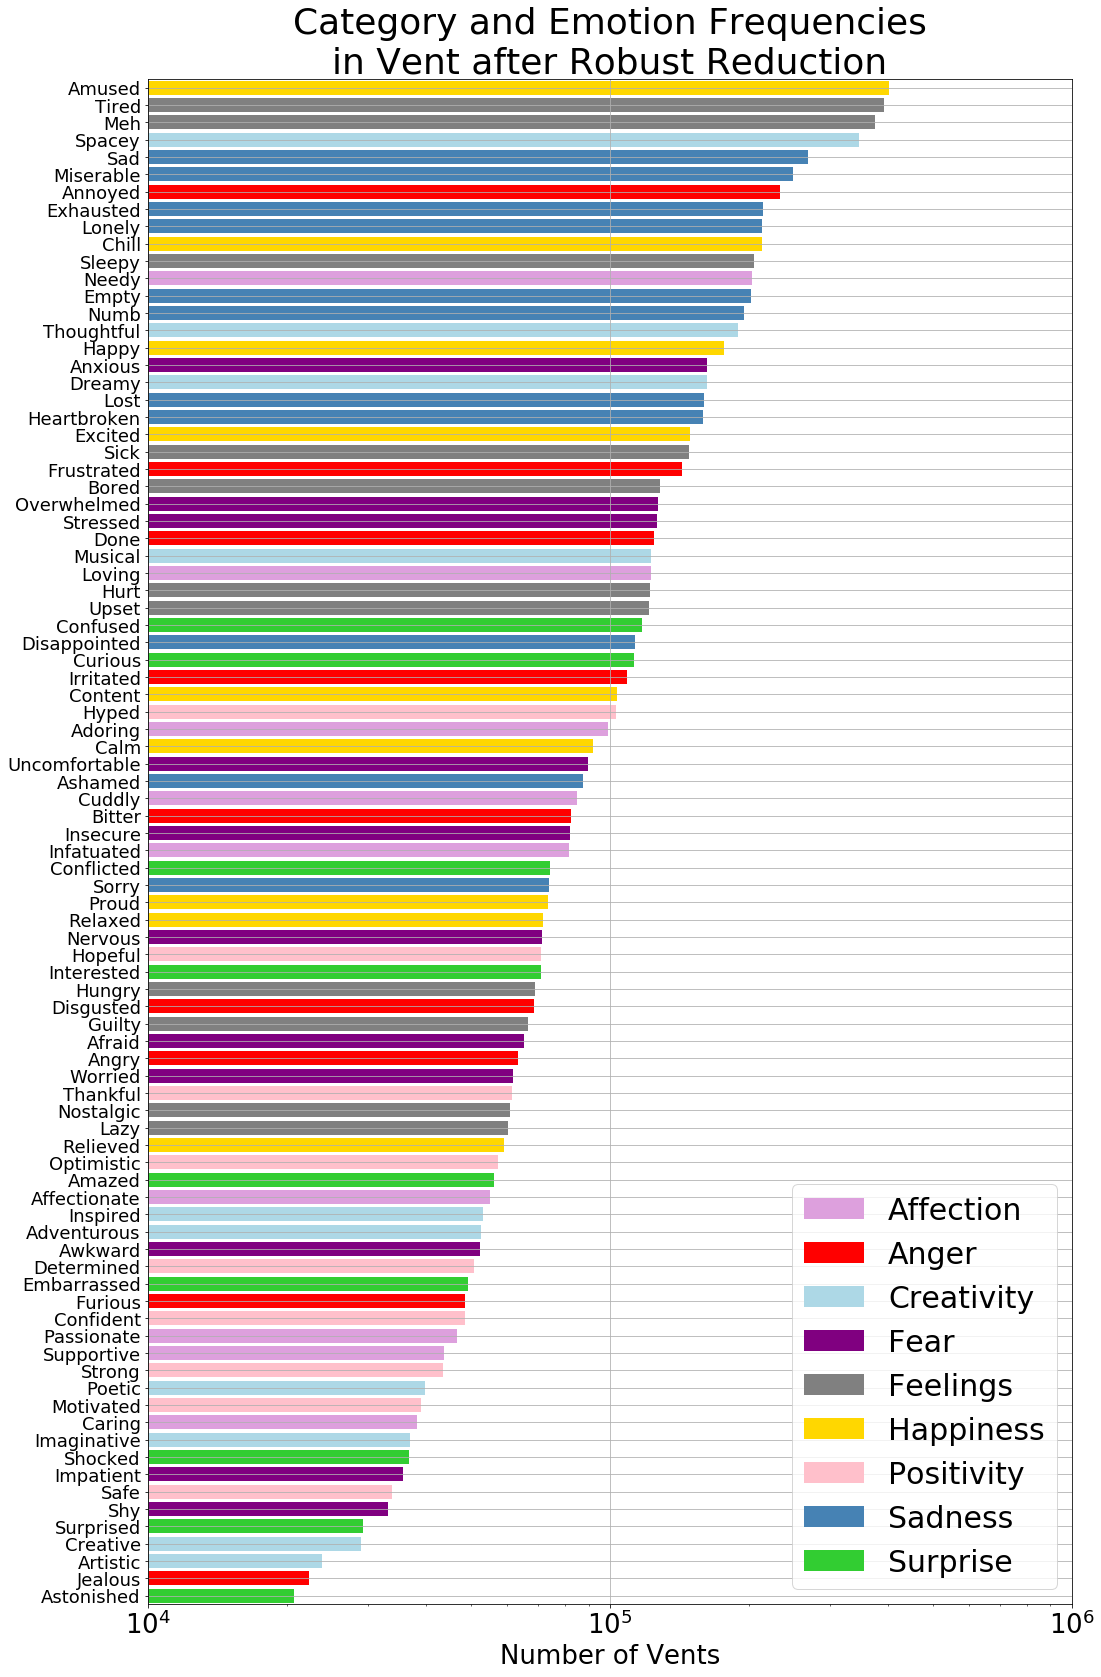

In [34]:
import matplotlib.patches as mpatches


robust_by_count = all_robust_counts[all_robust_counts.emotion.isin(robust_emotion_set)].sort_values('count', ascending=True)
print('There are {} vents after robust filtering.'.format(all_robust_counts['count'].sum()))
num_emos = len(robust_emotion_set)

# Prepare the data
y_pos = np.arange(0.5, num_emos, 1.0) 
categories = robust_by_count.category.tolist()
category_set = sorted(set(categories))
num_cats = len(category_set)
color_map = {cat: col for cat, col in zip(category_set, color_list)}
colors = [color_map[cat] for cat in categories]
all_hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_map = {cat: all_hatches[i] for i, cat in enumerate(category_set)}
hatches = [hatch_map[cat] for cat in categories]

# Set the environment
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(16, 24))
plt.xscale('log')
plt.ylim(0, num_emos)
plt.yticks(y_pos, robust_by_count.emotion.tolist())

# Plot each line with hatches
for category in category_set:
    y, c, cat, col, hat = zip(*[t for t in zip(y_pos, robust_by_count['count'].tolist(), categories, colors, hatches) if t[2] == category])
    col = col[0]
    hat = hat[0]
    plt.barh(y, c, label=cat, color=col)# , hatch=hat)

matplotlib.rcParams.update({'font.size': 30})
plt.xlabel('Number of Vents', fontsize=26)
plt.xticks(fontsize=26)
plt.xlim(1e4, 1e6)
plt.title('Category and Emotion Frequencies\nin Vent after Robust Reduction')
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set]) #  hatch=hatch_map[cat]
plt.grid()
plt.tight_layout()
plt.savefig('../output/VentEmotionAndCategoryFrequenciesRobust.pdf')

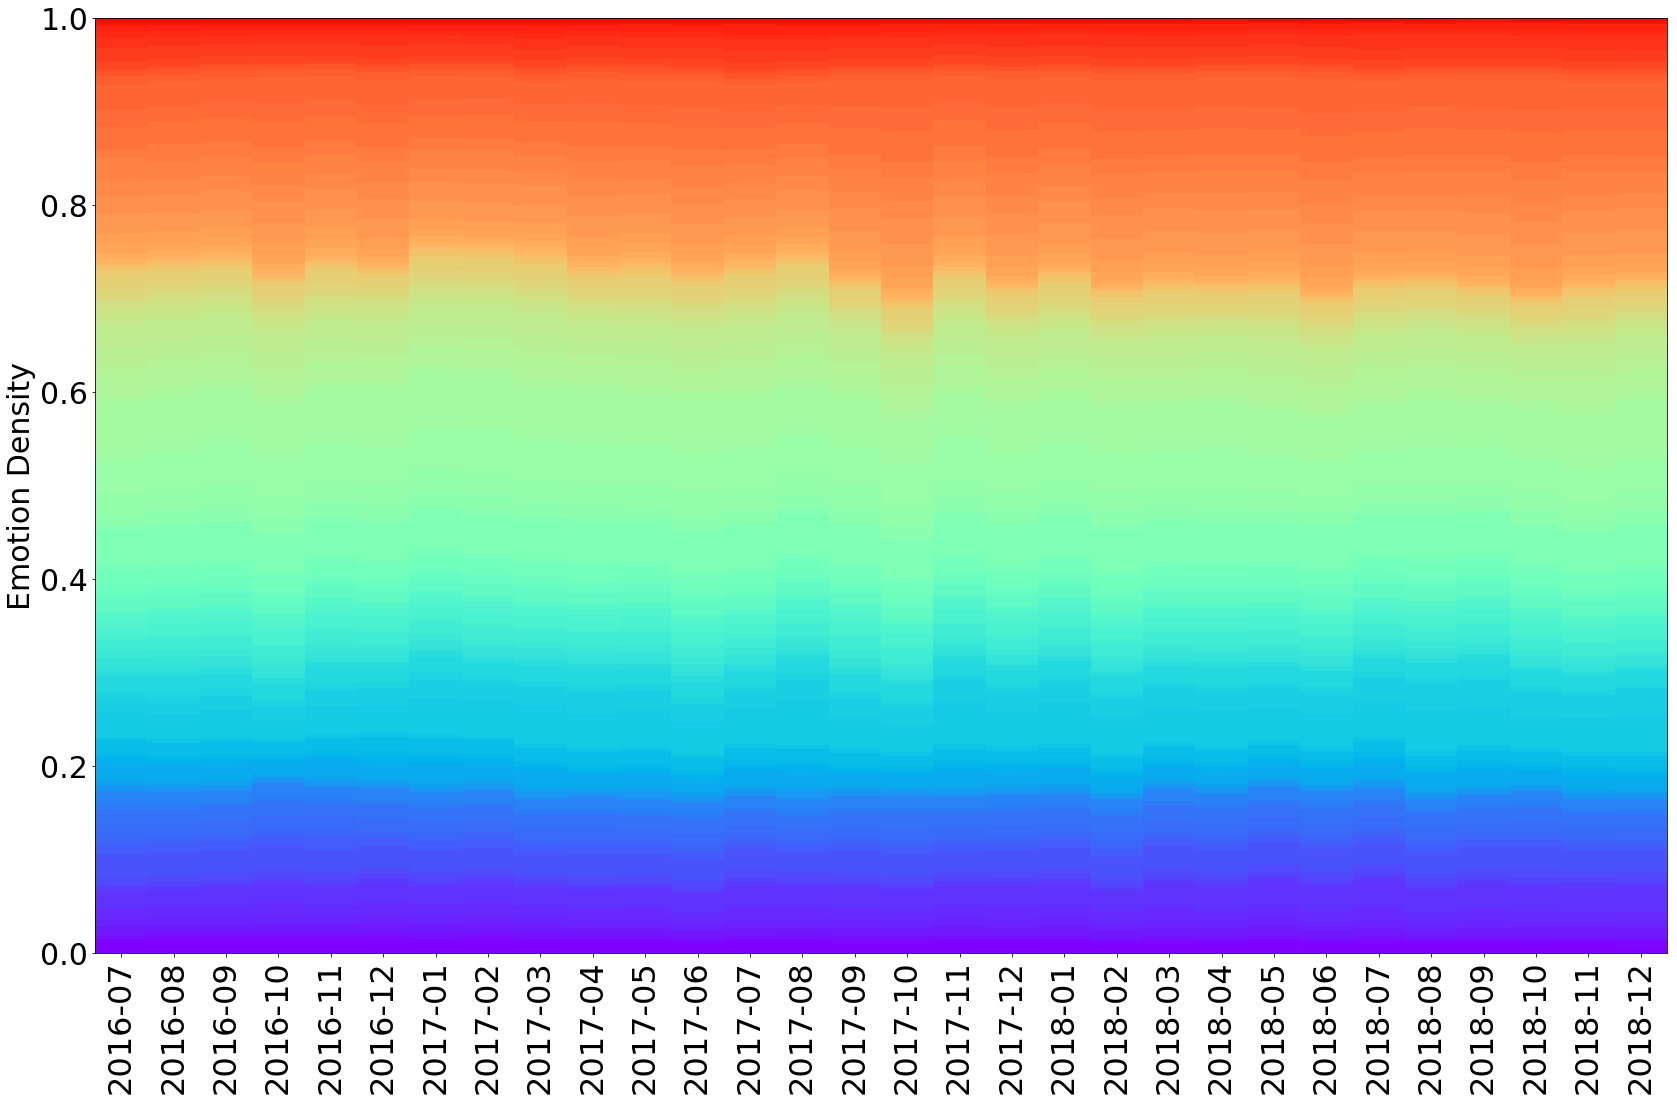

In [50]:
plt.figure(figsize=(24, 16))

index = 0.5
width = 1
matplotlib.rcParams.update({'font.size': 30})
for grp, df in after_plateau.groupby('month'):
    prob_pre_sum = 0.0
    for i, row in df.iterrows():
        if row.emotion not in robust_emotion_set:
            prob_pre_sum += row.percent
    prob_sum = 0.0
    for i, row in df.sort_values(['category', 'emotion']).iterrows():
        if row.emotion not in robust_emotion_set:
            continue
        pct = row.percent * (1 / (1 - prob_pre_sum))
        plt.bar(index, height=pct, width=width, bottom=prob_sum, label=row.month, color=row.coloring)
        prob_sum += pct
    index += 1
    
robust_months = after_plateau.month.unique()
plt.xticks([x + 0.5 for x in range(len(robust_months))], robust_months, rotation='vertical', fontsize=32) 
plt.xlim(0, len(robust_months))
plt.ylim(0, 1)
#plt.title('Robust Emotion Densities over Vent Month-by-Month')
plt.ylabel('Emotion Density')
plt.tight_layout()
plt.show()

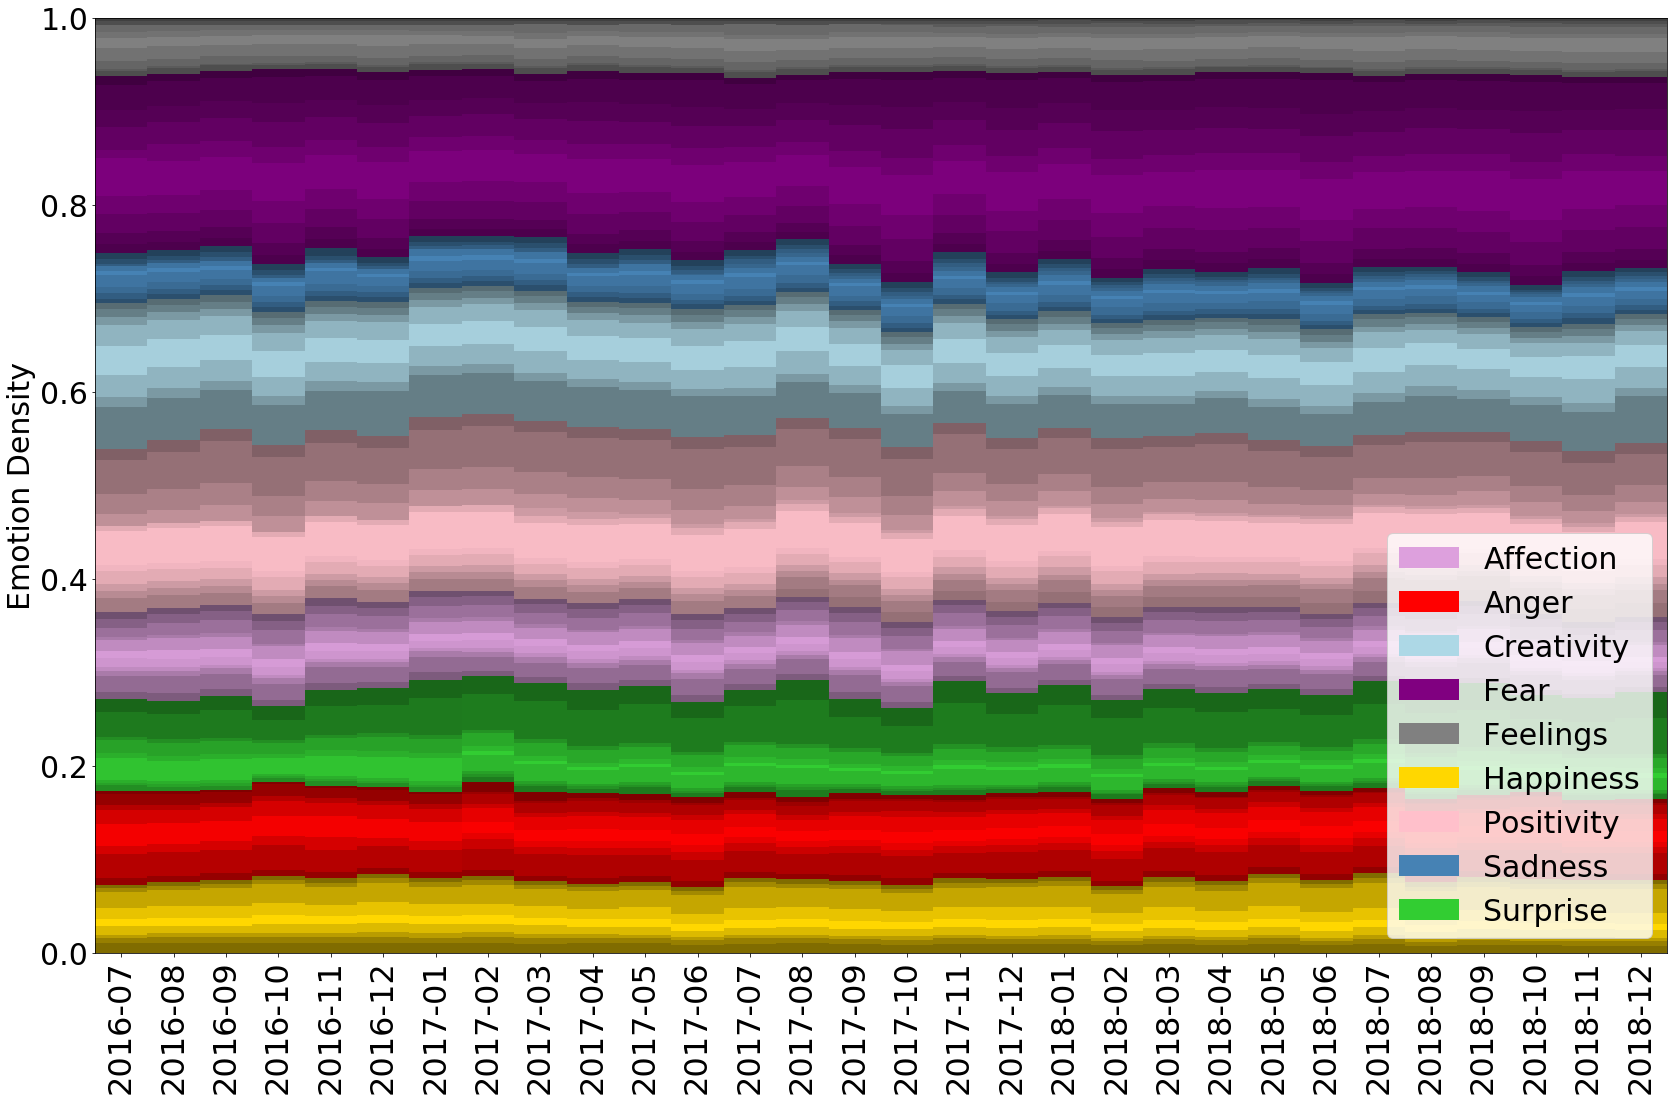

In [51]:
plt.figure(figsize=(24, 16))

def compute_color(cat_color, row_gray, center, delta, whitening_fraction=0.5):
    centered_gray = 1 - abs(center - row_gray) / delta
    whitened_gray = whitening_fraction * centered_gray + (1 - whitening_fraction)
    clipped_gray = min(1, max(0, whitened_gray))
    clipped_color = clipped_gray * cat_color
    return clipped_color

def compute_category_stats(month_df):
    top_colors = month_df.groupby('category').graybase.max().reset_index()
    top_colors.columns = ['category', 'cmax']
    top_colors['cmin'] = [0] + top_colors.cmax.tolist()[:-1]
    top_colors['delta'] = (top_colors.cmax - top_colors.cmin) / 2
    top_colors['center'] = top_colors.cmin + top_colors.delta
    return top_colors

index = 0.5
width = 1
matplotlib.rcParams.update({'font.size': 30})
for grp, df in after_plateau.groupby('month'):
    prob_sum = 0.0
    df['graybase'] = [gray[0] for gray in df.gray]
    category_stats = compute_category_stats(df)
    for i, row in df.sort_values(['category', 'emotion']).iterrows():
        pct = row.percent
        cat_color = category_colors[row.category]
        cat = category_stats[category_stats.category == row.category].iloc[0]
        delta = 1 if cat.delta == 0 else cat.delta
        full_color = tuple(map(lambda x: compute_color(x[0], x[1], cat.center, delta), zip(cat_color, row.gray[:3])))
        plt.bar(index, height=pct, width=width, bottom=prob_sum, label=row.month, color=full_color)
        prob_sum += pct
    index += 1
    
robust_months = after_plateau.month.unique()
plt.xticks([x + 0.5 for x in range(len(robust_months))], robust_months, rotation='vertical', fontsize=32) 
plt.xlim(0, len(robust_months))
plt.ylim(0, 1)
plt.legend(handles=[mpatches.Patch(facecolor=color_map[cat], label=cat) for cat in category_set], loc='lower right') #  hatch=hatch_map[cat]
#plt.title('Robust Emotion Category Densities over Vent Month-by-Month')
plt.ylabel('Emotion Density')
plt.tight_layout()
plt.savefig('../output/EmoCategoryRobustDensitiesMonthly.pdf')
plt.show()